# Exact Simulation Workbook

This runs a couple of simulations to show where we are up to.

First, it runs a simulation using the Euler scheme. The process it simulates is equation 5.1 from the reference paper. This method works correctly. The code outputs (some of) the paths generated. It also outputs the volatility smile. Note that the volatility smile matches the smile in Figure 1 on page 18 of the reference paper.

Next, it runs a simulation of the same process (equation 5.1), this time using the Exact method. Something is not working properly with this. The prices that it outputs are sometimes negative which is obviously wrong.

The output for each method is the $E[max(X_T-K, 0)]$ for a range of K, along with the implied volatility. Each method also generates a plot of (some of) the simulated paths.

In [61]:
source('coefficients.r')
source('general_euler_multi_d.r')
source('driftless_exact_multi_d.r')
source('drifted_exact_multi_d.r')
source('simulations.r')

In [4]:
# # defined elsewhere
# make_mu_section_52_euler <- function(d){
#     function(t, x){x[d,]*0.1*(sqrt(x[d,]) - 1)}
# }
# make_sigma_section_52_euler <- function(d){
#     function(t, x){0.5*x[d,]}
# }

# library(MASS)

# # passed in
# cov_matrix <- matrix(.7, nrow=4, ncol=4) + diag(4)*.3
# num_of_paths <- 2
# num_of_steps <- 5
# T <- 1
# X0 <- rep(1, 4)
# mu <- sapply(1:4, make_mu_section_52_euler)
# sigma <- sapply(1:4, make_sigma_section_52_euler)

# num_dim <- nrow(cov_matrix)
# dt <- T/num_of_steps
# dW <- mvrnorm(n=num_of_paths*num_of_steps, mu=rep(0, num_dim), Sigma=cov_matrix*dt)
# dW <- t(dW)
# dim(dW) <- c(num_dim, num_of_steps, num_of_paths)
# X <- array(rep(NA, num_dim*(num_of_steps+1)*num_of_paths), c(num_dim, num_of_steps+1, num_of_paths))
# X[,1,] <- X0
# for (t in 1:num_of_steps){
#     for (d in 1:num_dim){
#         X[d,t+1,] <- X[d,t,] + mu[[d]]((t-1)*dt, X[,t,]) * dt + sigma[[d]]((t-1)*dt, X[,t,]) * dW[d,t,]
#     }
# }
# X_Ts <- X[,ncol(X),]
# X_Ts
# make_basket_call_payoff <- function(K){
#     function(x) pmax(colMeans(x)-K, 0)
# }

## Global Parameters

In [62]:
T <- 1
X0 <- 1
strikes <- seq(0.6, 1.5, by=0.1)
allImpVols <- data.frame(K=strikes) # Save to global object for overlaid plots

## Euler scheme
### Parameters

In [63]:
numPathsEuler <- 10000
numStepsEuler <- 100

### Driftless process (equation 5.1)
$$ X_0=1, \,\,\,\, dX_t=\frac{2\sigma}{1+X_t^2}dW_t $$

In [ ]:
# Some other mu and sigma functions to try out
#sigma <- make_affine_coefficient(1, 0) # Black-Scholes with sigma <- 1
#mu <- make_mean_reverting_coefficient(0.8, 1.0)
#sigma <- make_constant_coefficient(1)

euler51_process <- General_Euler(numPathsEuler, numStepsEuler,
                                 mu=make_constant_coefficient(0),
                                 sigma=sigma_from_paper,
                                 T=T, X0=X0)
run_euler(euler51_process, strikes, T, X0, saveColumn='Euler 5.1')

### Drifted process (equation 5.2)
$$ Y_0=0, \,\,\,\, dY_t = \frac{2\sigma X_t}{\left(1+X_t^2\right)^2}dt+dW_t 
\,\,\,\,
\mbox{where}
\,\,\,\,
2\sigma Y_t = X_t-X_0+\frac{X_t^3 - X_0^3}3 $$

In [5]:
euler52_process <- General_Euler(numPathsEuler, numStepsEuler,
                                 mu_from_paper,
                                 sigma=make_constant_coefficient(1),
                                 T=T, X0=0)
run_euler(euler52_process, strikes, T, X0, convert_y_to_x, saveColumn='Euler 5.2')

ERROR: Error in eval(expr, envir, enclos): could not find function "General_Euler"


ERROR: Error in run_euler(euler52_process, strikes, T, X0, convert_y_to_x, saveColumn = "Euler 5.2"): object 'euler52_process' not found


### Drifted Multi-Dimensional (Section 5.2)
$$\frac{dX_t^i}{X_t^i}=\frac12dW_t^i + .1(\sqrt{X_t^i}-1)dt
\,\,\,\,
\mbox{where}
\,\,\,\,
X_0^i=1,
\,\,\,\,
d\langle W^i,W^j\rangle_t=.5dt,
\,\,\,\,
i\neq j=1,...,d.$$

In [44]:
source('general_euler_multi_d.r')
source('black_scholes.r')
d <- 4
euler_section_52_process <- General_Euler_Multi_D(numPathsEuler, numStepsEuler,
                                 mu=sapply(1:d, make_mu_section_52_euler),
                                 sigma=sapply(1:d, make_sigma_section_52_euler),
                                 cov_matrix=matrix(.5, nrow=d, ncol=d) + diag(d)*.5,
                                 T=T, X0=X0)

     K      price implied.vol
1  0.6 0.42099789   0.4440471
2  0.7 0.34045320   0.4298725
3  0.8 0.27090462   0.4231881
4  0.9 0.21262407   0.4192759
5  1.0 0.16510433   0.4168538
6  1.1 0.12722012   0.4153946
7  1.2 0.09736647   0.4141672
8  1.3 0.07419841   0.4132719
9  1.4 0.05642652   0.4127312
10 1.5 0.04279866   0.4121660


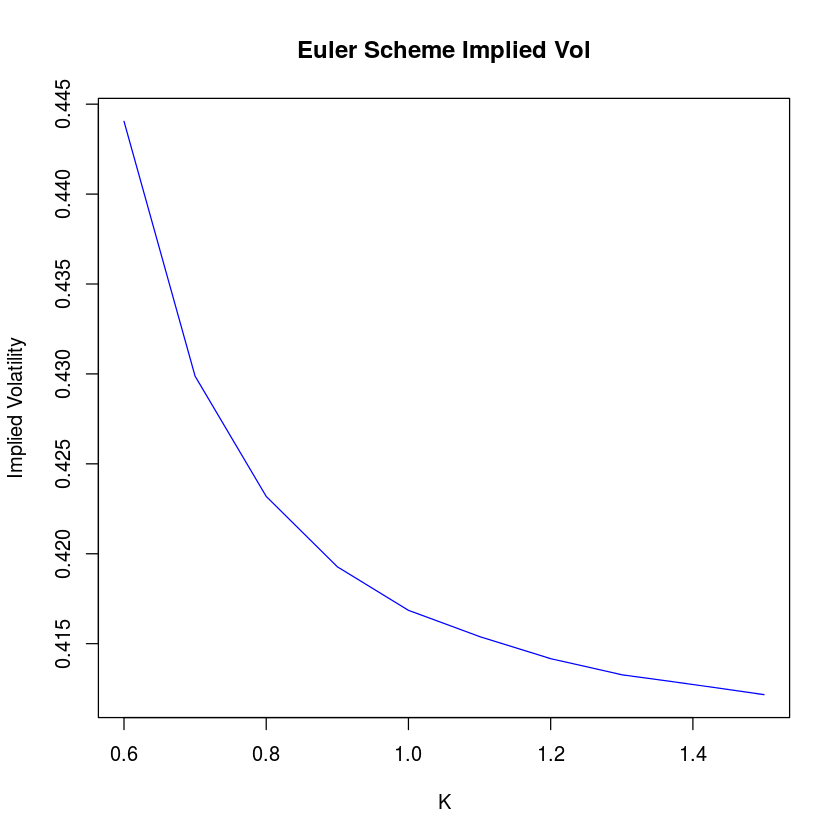

In [45]:
source('simulations.r')
source('payoffs.r')
run_euler(euler_section_52_process, strikes, T, X0[1], make_basket_call_payoff, saveColumn='Euler Section 5.2')

## Exact method
### Parameters

In [64]:
numPathsExact <- 10000
beta <- 0.2

### Driftless process (equation 5.1)
$$ X_0=1, \,\,\,\, dX_t=\frac{2\sigma}{1+X_t^2}dW_t $$

In [ ]:
exact51_process <- Driftless_Exact(numPathsExact, beta, sigma_from_paper, sigma_deriv_from_paper, T, X0)
run_exact(exact51_process, strikes, T, X0, saveColumn='Exact 5.1')

### Drifted process (equation 5.2)
$$ Y_0=0, \,\,\,\, dY_t = \frac{2\sigma X_t}{\left(1+X_t^2\right)^2}dt+dW_t 
\,\,\,\,
\mbox{where}
\,\,\,\,
2\sigma Y_t = X_t-X_0+\frac{X_t^3 - X_0^3}3 $$

In [65]:
exact52_process <- Drifted_Exact(numPathsExact, beta,
                                 mu_from_paper,
                                 sigma0=1,
                                 T=T, X0=0,
                                 convert_y_to_x_func=convert_y_to_x)
run_exact(exact52_process, strikes, T, X0, saveColumn='Exact 5.2')

ERROR: Error in eval(expr, envir, enclos): could not find function "Drifted_Exact"


ERROR: Error in run_exact(exact52_process, strikes, T, X0, saveColumn = "Exact 5.2"): object 'exact52_process' not found


### Example mean reverting process
$$ X_0=1, \,\,\,\, dX_t=0.8(X_t-1)dt+dW_t $$

In [ ]:
drifted_process <- Drifted_Exact(numPathsExact, beta,
                                 mu=make_mean_reverting_coefficient(0.8, 1),
                                 sigma0=1,
                                 T=T, X0=X0)
run_exact(drifted_process, strikes, T, X0)

### Example linear drift process
$$ X_0=1, \,\,\,\, dX_t=tdt+dW_t $$

In [ ]:
lin_drift_exact_process <- Drifted_Exact(numPathsExact, beta, mu=function(t,x) t, sigma0=1, X0=1)
run_exact(lin_drift_exact_process, strikes, T, X0=1, saveColumn='Linear Drift Exact')

lin_drift_euler_process <- General_Euler(numPathsEuler, numStepsEuler,
                                         mu=function(t,x) t,
                                         sigma=make_constant_coefficient(1),
                                         X0=1)
run_euler(lin_drift_euler_process, strikes, T, X0=1, saveColumn='Linear Drift Euler')

## Comparing Implied Volatilities

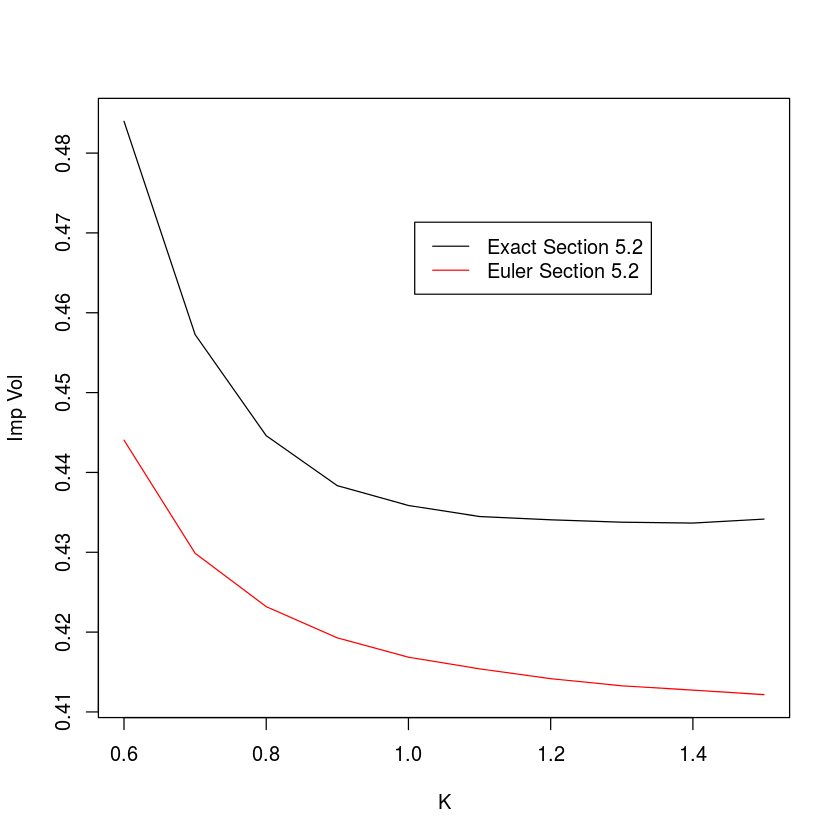

In [48]:
matplot(allImpVols$K,allImpVols[names(allImpVols)!='K'], xlab='K', ylab='Imp Vol', type='l', lty=1)
legend('topright', inset=.2, legend=names(allImpVols)[names(allImpVols)!='K'], lty=1, col=1:(ncol(allImpVols)-1))

## Multi-dimensional SDE (Section 5.2)
See <a href="http://www.r-bloggers.com/easily-generate-correlated-variables-from-any-distribution-without-copulas">here</a> for potential implementation.

In [13]:
# # library(MASS)
# # num_of_steps <- 2
# # num_dim <- 3
# # cov_matrix <- 
# # mvrnorm(n=num_of_steps, mu=rep(0, num_dim), Sigma=dt*cov_matrix)

# # defined elsewhere
# make_mu_section_52_lamperti <- function(d){
#     function(t, y){
#         X0 <- 1
#         x <- matrix(convert_y_to_x_multi_d(y))
#         return(0.2*X0*(sqrt(x[d])-1) - 0.25*X0)
#     }
# }

# convert_y_to_x_multi_d <- function(y){
#     X0 <- 1.0
#     return(X0*exp(0.5*y))
# }

# library(MASS)
# source("poisson_process.r")

# # passed in
# cov_matrix <- matrix(.5, nrow=4, ncol=4) + diag(4)*.5
# T <- 1
# X0 <- rep(1, 4)
# beta <- 1
# mu <- sapply(1:4, make_mu_section_52_lamperti)
# sigma0 <- diag(X0)
# #mu <- sapply(1:4, make_mu_section_52_euler)
# #sigma <- sapply(1:4, make_sigma_section_52_euler)

# num_dim <- nrow(cov_matrix)
# poisson <- Poisson_Process(beta, T)
# dW <- matrix(NA, nrow=num_dim, ncol=length(poisson$dt))
# for (i in 1:length(poisson$dt)){
#     dW[,i] <- mvrnorm(n=1, mu=rep(0, num_dim), Sigma=poisson$dt[i]*cov_matrix)
# }
# Y0 <- 2*log(X0/X0)
# Yhat <- cbind(Y0, matrix(NA, nrow=num_dim, ncol=length(poisson$t)-1))

# for (k in 1:(length(poisson$t)-1)){
#     for (d in 1:num_dim){
#         Yhat[d,k+1] <- Yhat[d,k] + mu[[d]](poisson$t[k], Yhat[,k])*poisson$dt[k+1] + sigma0[d,d]*dW[d,k+1]
#     }
# }

# Yhat
# Xhat <- convert_y_to_x_multi_d(Yhat)
# Xhat

# malliavin_weight <- function(k){
#     # Generate the Malliavin weights. Needed to calculate psi.
#     #
#     # Args:
#     #     k (int): The subscript index to identify which weight to calculate.
#     mu_diffs <- sapply(1:num_dim, function(d) mu[[d]](poisson$t[k], Xhat[,k]) - mu[[d]](poisson$t[k-1], Xhat[,k-1]))
#     return(mu_diffs %*% solve(sigma0) %*% dW[,k+1] / poisson$dt[k+1])
# }
        
# psi <- function(g){
#     # Calculate psi from the reference paper.
#     # E[psi] <- E[g(X_T)] where X_T is the last step of the standard Euler scheme process.
#     #
#     # Args:
#     #     g (function): A function taking X_T and returning a scalar
#     # Returns:
#     #     float: An estimator in expectation for g(X_T)
#     return((g(Xhat[,ncol(Xhat)]) - ifelse(N_T > 0, g(Xhat[,ncol(Xhat)-1]), 0)) * g_multiple)
# }

# make_basket_call_payoff_exact <- function(K)
#     function(x) {
#         max(mean(x)-K, 0)
#     }
# g_maker <- make_basket_call_payoff_exact
# totals <- rep(0,length(strikes))

# N_T <- length(poisson$t) - 2
# product <- ifelse(N_T>0, prod(sapply(2:(1+N_T), malliavin_weight)), 1)
# g_multiple <- exp(beta*T) * beta^-N_T * product
# totals <- totals + sapply(strikes, function(K) psi(g_maker(K)))
# totals

# # X_Ts <- X[,ncol(X),]
# # X_Ts
# # make_basket_call_payoff <- function(K){
# #     function(x) pmax(colMeans(x)-K, 0)
# # }

Y0,,,
0.0000000,-0.3320724,-0.9827049,-0.6335515
0.0000000,0.1370511,-0.9084266,-1.0217385
0.00000000,0.11638739,-0.01003871,0.57374354
0.0000000,0.0950992,-0.4924930,-0.7246982


Y0,,,
1.0000000,0.8470156,0.6117984,0.7284941
1.0000000,1.0709280,0.6349473,0.5999738
1.0000000,1.0599203,0.9949932,1.3322534
1.0000000,1.0486982,0.7817295,0.6960393


[1] 1.511425e-05 1.511425e-05 7.108837e-06 0.000000e+00 0.000000e+00
 [6] 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00

In [59]:
source('drifted_exact_multi_d.r')

d <- 4
numPathsExact <- 1000
X0 <- rep(1, d)
exact_section_52_process <- Drifted_Exact_Multi_D(numPathsExact, beta,
                                 mu=sapply(1:d, make_mu_from_paper_multi_dimension_lamperti),
                                 sigma0=diag(X0),
                                 cov_matrix=matrix(.5, nrow=d, ncol=d) + diag(d)*.5,
                                 T=T, X0=X0,
                                     convert_y_to_x=convert_y_to_x_multi_d,
                                 convert_x_to_y=convert_x_to_y_multi_d)

 [1] 0.42806487 0.34801943 0.27822825 0.21850135 0.16788478 0.12847849
 [7] 0.09728933 0.07361045 0.05502610 0.04044477
     K      price implied.vol
1  0.6 0.42806487   0.4869857
2  0.7 0.34801943   0.4618848
3  0.8 0.27822825   0.4471593
4  0.9 0.21850135   0.4356539
5  1.0 0.16788478   0.4239790
6  1.1 0.12847849   0.4185495
7  1.2 0.09728933   0.4139685
8  1.3 0.07361045   0.4116555
9  1.4 0.05502610   0.4084923
10 1.5 0.04044477   0.4041085


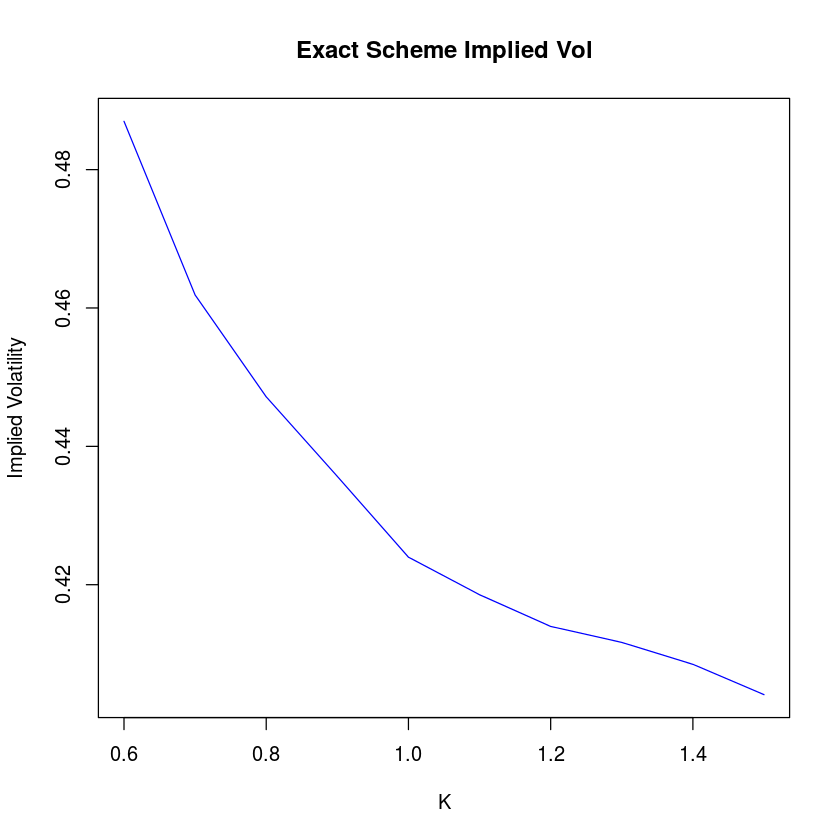

In [60]:
source('drifted_exact_multi_d.r')
source('simulations.r')
source('payoffs.r')
run_exact(exact_section_52_process, strikes, T, X0[1], make_basket_call_payoff_exact, saveColumn='Exact Section 5.2')

[1] 3.00064


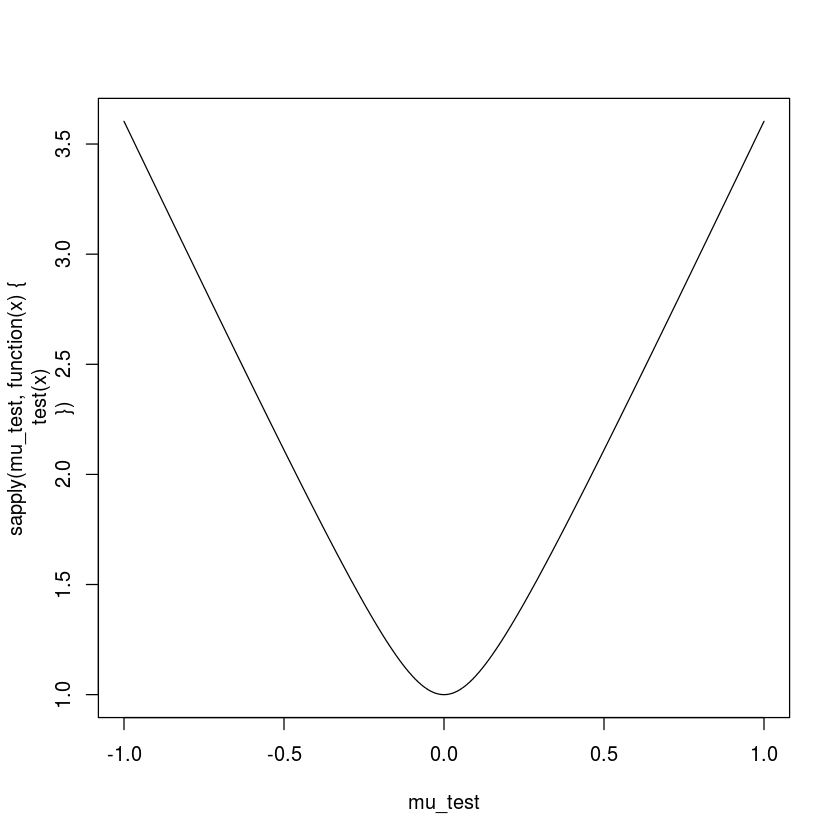

In [37]:
# TEST
source('beta_calculator.r')
L <- 0.8
T <- 1.0
mu0 <- c(0.3)
sigma0 <- c(1)*diag(1)

print(beta_calculator(L, T, mu0, sigma0))
mu_test <- seq(-1,1,0.01)
plot(mu_test, sapply(mu_test, function(x){test(x)}), 'l')